In [1]:
%matplotlib inline

import os
from tqdm import tqdm, tqdm_notebook, tqdm_pandas
from tqdm import trange
import time
from scipy import stats
from scipy.stats import shapiro

import pandas as pd
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt

import itertools
from modules.kidera import score_positions, score_sequence

import warnings
warnings.filterwarnings('ignore')

In [6]:
df = pd.read_csv("output/netMHCpan/HLA-A02:01_NMP_9mer_proc.txt", sep=' ')
df = df[df['Aff(nM)'] <= 500]
df.index = range(len(df))
df.head()

HLA    Peptide  Aff(nM)
0  HLA-A*02:01  AAAGLVPLV    245.0
1  HLA-A*02:01  AAAGNPFPV    166.4
2  HLA-A*02:01  AAAGTFLAV    251.2
3  HLA-A*02:01  AAAGVLAGV     60.7
4  HLA-A*02:01  AAAGVLMAI    464.3

In [7]:
tqdm.pandas(desc="progress")

In [8]:
df1 = pd.concat([df, df.Peptide.progress_apply(lambda s: score_sequence(s))], axis=1)
df1.head()

progress: 100%|██████████| 332404/332404 [20:39<00:00, 268.13it/s]


HLA    Peptide  Aff(nM)         1         2         3         4  \
0  HLA-A*02:01  AAAGLVPLV    245.0 -0.524444 -0.968889 -0.076667 -0.524444   
1  HLA-A*02:01  AAAGNPFPV    166.4  0.121111 -0.825556 -0.431111 -0.387778   
2  HLA-A*02:01  AAAGTFLAV    251.2 -0.723333 -1.007778 -0.162222 -0.393333   
3  HLA-A*02:01  AAAGVLAGV     60.7 -0.648889 -1.335556 -0.055556 -0.366667   
4  HLA-A*02:01  AAAGVLMAI    464.3 -0.965556 -1.036667 -0.104444 -0.471111   

          5         6         7         8         9        10  
0 -0.212222 -0.957778  0.088889 -0.175556 -0.034444  0.211111  
1 -0.003333 -0.511111  0.092222 -0.010000  0.311111 -0.340000  
2 -0.394444 -0.743333  0.146667  0.143333  0.035556 -0.014444  
3 -0.341111 -0.778889  0.073333  0.417778 -0.327778  0.136667  
4 -0.245556 -0.504444 -0.017778  0.217778 -0.160000 -0.154444

In [9]:
df1.columns = ['HLA', 'Peptide', 'Affinity', "helix.bend.pref", "side.chain.size",\
               "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
               "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]

In [10]:
df2 = df1.drop(['HLA', 'Affinity'], axis=1)
df2.head()

Peptide  helix.bend.pref  side.chain.size  extended.str.pref  \
0  AAAGLVPLV        -0.524444        -0.968889          -0.076667   
1  AAAGNPFPV         0.121111        -0.825556          -0.431111   
2  AAAGTFLAV        -0.723333        -1.007778          -0.162222   
3  AAAGVLAGV        -0.648889        -1.335556          -0.055556   
4  AAAGVLMAI        -0.965556        -1.036667          -0.104444   

   hydrophobicity  double.bend.pref  partial.spec.vol  flat.ext.pref  \
0       -0.524444         -0.212222         -0.957778       0.088889   
1       -0.387778         -0.003333         -0.511111       0.092222   
2       -0.393333         -0.394444         -0.743333       0.146667   
3       -0.366667         -0.341111         -0.778889       0.073333   
4       -0.471111         -0.245556         -0.504444      -0.017778   

   occurrence.alpha.reg      pK.C  surrounding.hydrop  
0             -0.175556 -0.034444            0.211111  
1             -0.010000  0.311111           -0.340000  
2              0.143333  0.035556           -0.014444  
3              0.417778 -0.327778            0.136667  
4              0.217778 -0.160000           -0.154444

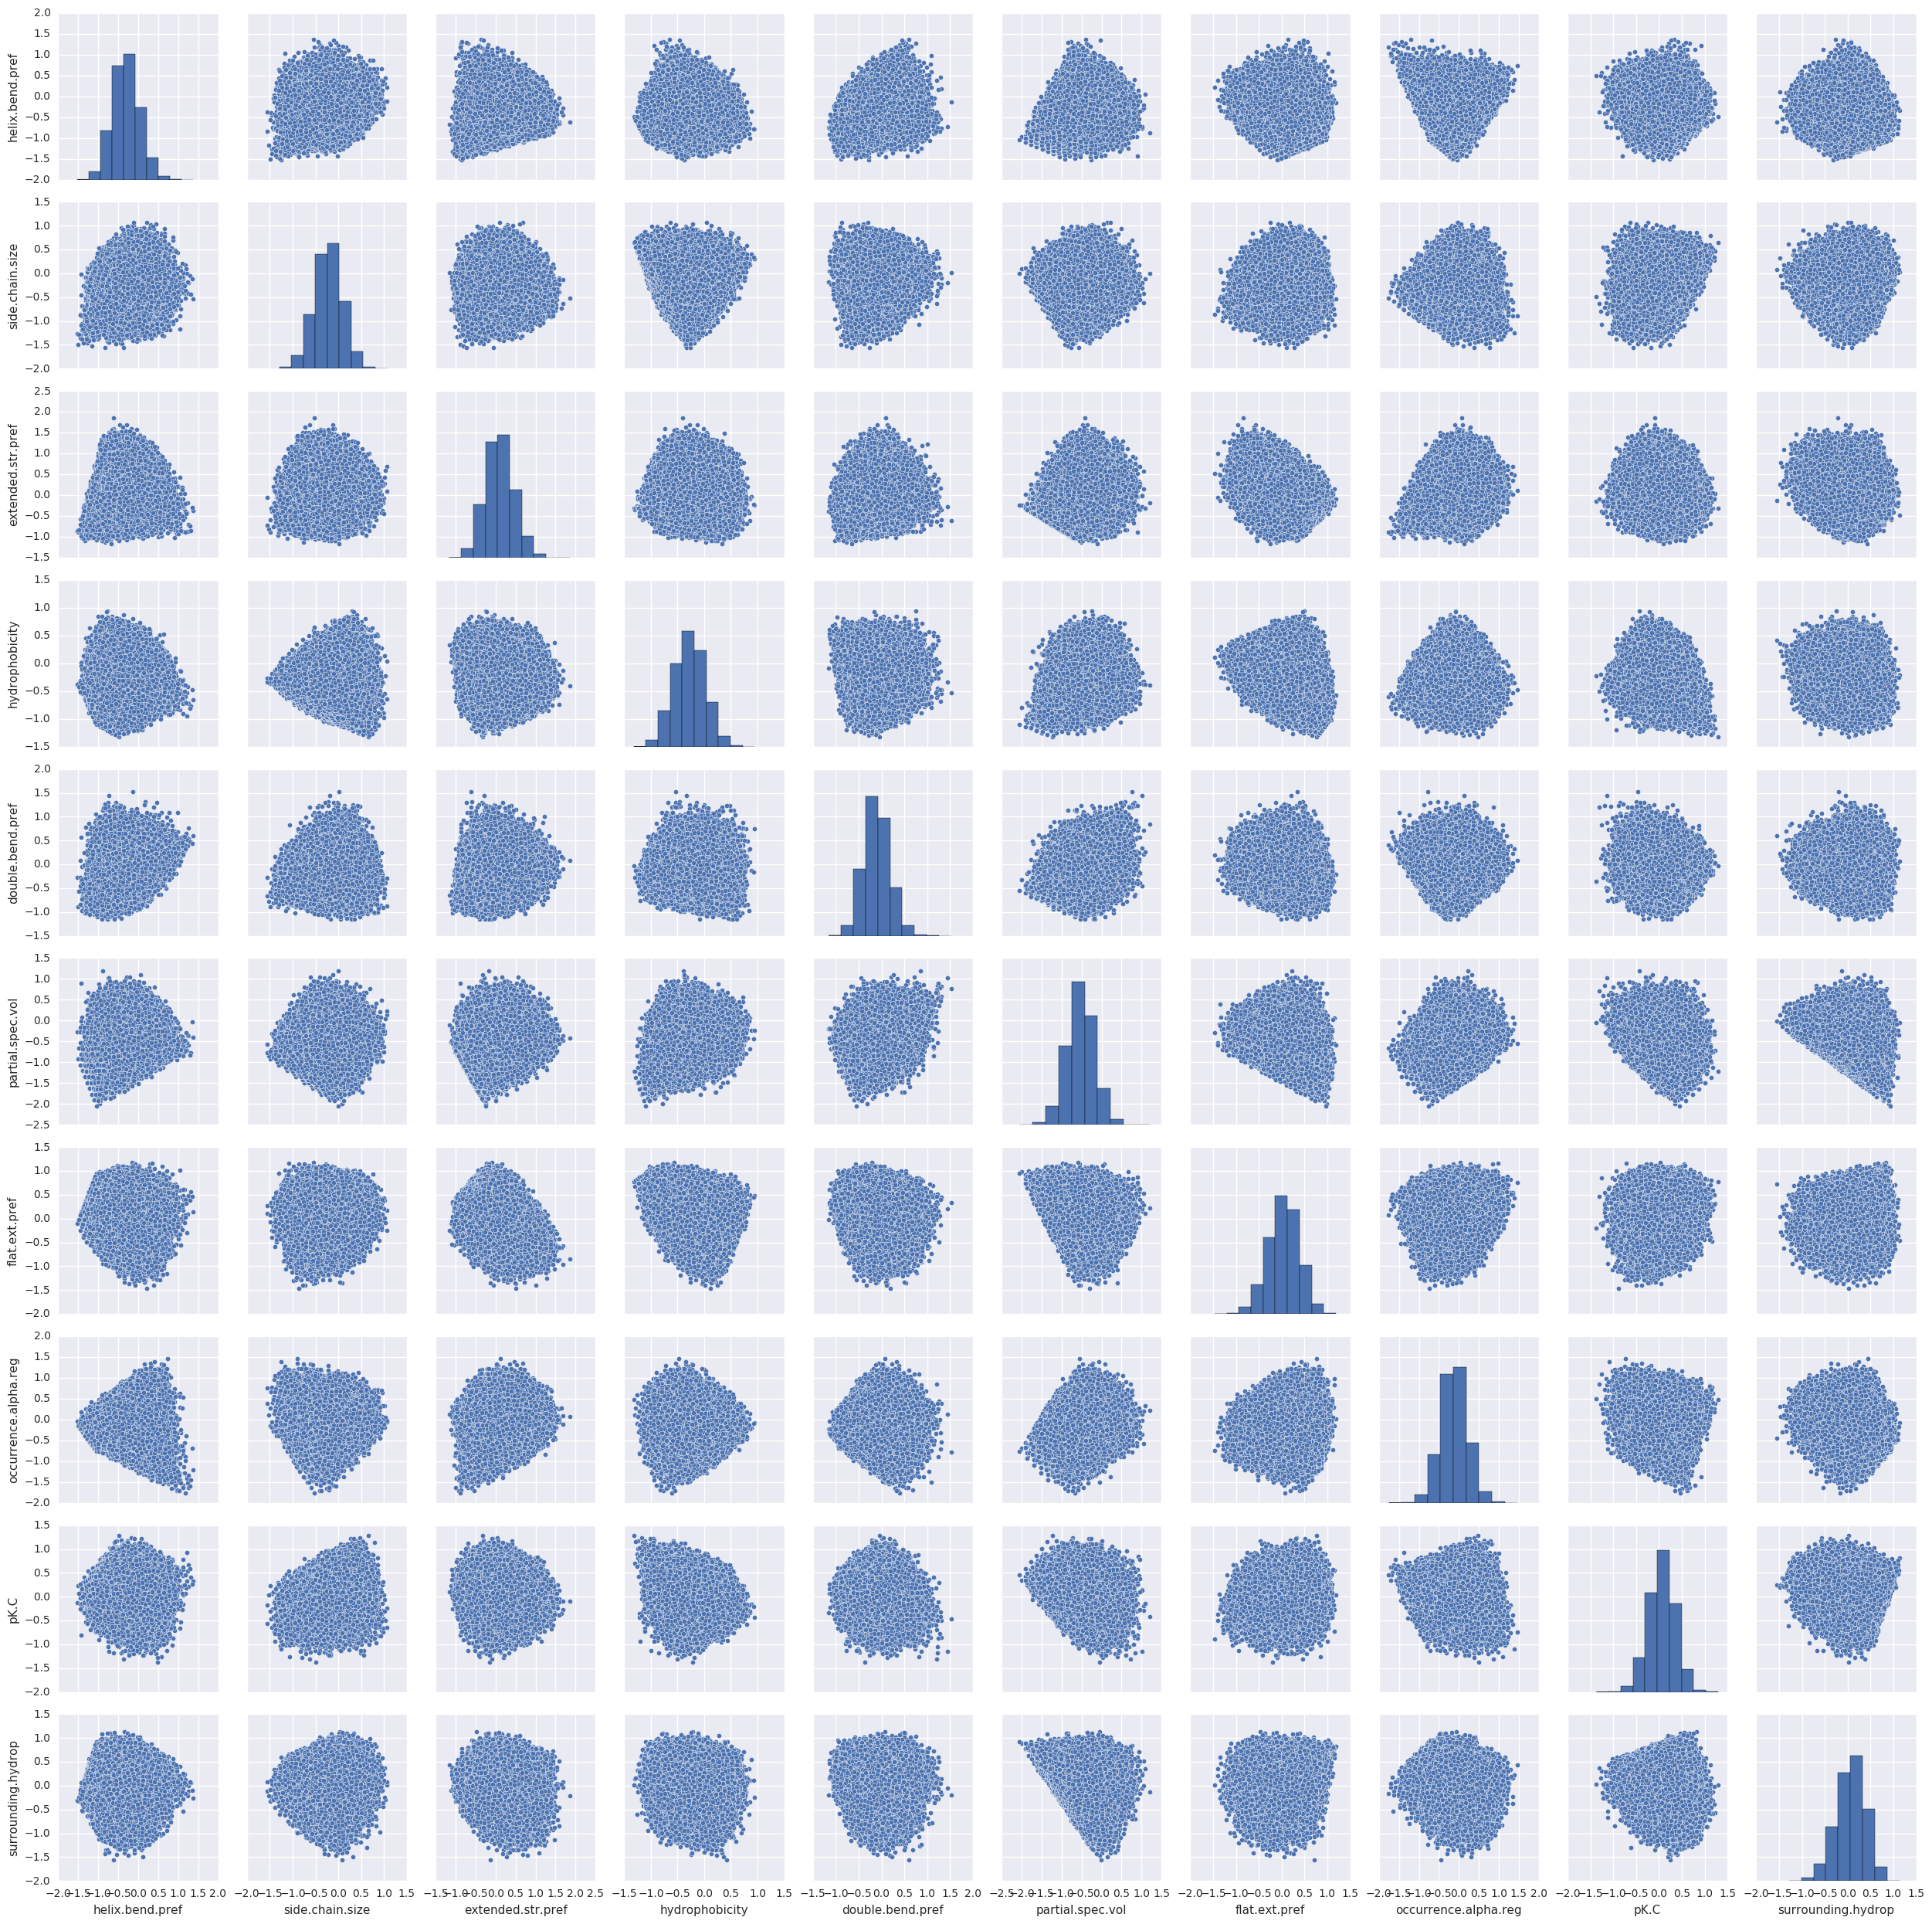

In [11]:
sns.pairplot(df2.drop('Peptide', axis=1))

In [12]:
df2.describe()

helix.bend.pref  side.chain.size  extended.str.pref  hydrophobicity  \
count    332404.000000    332404.000000      332404.000000   332404.000000   
mean         -0.300595        -0.219607           0.102133       -0.273447   
std           0.334486         0.305854           0.354786        0.291004   
min          -1.524444        -1.553333          -1.163333       -1.320000   
25%          -0.533333        -0.425556          -0.146667       -0.476667   
50%          -0.310000        -0.216667           0.091111       -0.271111   
75%          -0.077778        -0.011111           0.337778       -0.072222   
max           1.372222         1.067778           1.864444        0.945556   

       double.bend.pref  partial.spec.vol  flat.ext.pref  \
count     332404.000000     332404.000000  332404.000000   
mean          -0.104006         -0.524532       0.041780   
std            0.284052          0.347961       0.333240   
min           -1.152222         -2.050000      -1.468889   
25%           -0.301111         -0.754444      -0.181111   
50%           -0.116667         -0.525556       0.050000   
75%            0.080000         -0.294444       0.274444   
max            1.526667          1.201111       1.185556   

       occurrence.alpha.reg           pK.C  surrounding.hydrop  
count         332404.000000  332404.000000       332404.000000  
mean              -0.116603       0.060240            0.068903  
std                0.334620       0.288706            0.319834  
min               -1.754444      -1.370000           -1.552222  
25%               -0.340000      -0.130000           -0.138889  
50%               -0.118889       0.066667            0.088889  
75%                0.106667       0.257778            0.296667  
max                1.470000       1.290000            1.131111

In [13]:
df2.mean()

helix.bend.pref        -0.300595
side.chain.size        -0.219607
extended.str.pref       0.102133
hydrophobicity         -0.273447
double.bend.pref       -0.104006
partial.spec.vol       -0.524532
flat.ext.pref           0.041780
occurrence.alpha.reg   -0.116603
pK.C                    0.060240
surrounding.hydrop      0.068903
dtype: float64

Next I am going to plot mean values of aa properties for all alleles' binders

In [ ]:
# file_list = []
# for name in os.listdir("output/netMHCpan/"):
#     if "NMP" in name:
#         file_list.append(name)
# for i, s in enumerate(file_list):
#     file_list[i] = s.replace("_NMP_9mer_proc.txt", "")

Kidera Factors of human peptidome 9mers

In [2]:
pdf = pd.read_csv('output/kidera/hpeptides_9mers_kidera.csv')
idf1 = pd.read_csv('data/immunogenic_peptides.csv')
idf2 = pd.read_csv('data/immunogenic_peptides.txt', sep='\t')
idf2 = idf2[idf2['Species']=='Homo']
idf1 = idf1[idf1['Length']==9]
idf2 = idf2[idf2['Peptide'].str.len()==9]
idf1 = idf1.drop(['Epitope Start', 'Epitope End', ' Epitope Source Organism Name', 'Length'], axis=1)
idf2 = idf2.drop(['Species'], axis=1)
idf1.columns = ['Peptide', 'MHC', 'Immunogenicity']
idf1 = idf1.reset_index(drop=True)
idf2 = idf2.reset_index(drop=True)
idf = pd.concat([idf1, idf2], axis=0)
idf.Immunogenicity = idf.Immunogenicity.map({'immunogenic': 1, 'non-immunogenic': 0,
                                             'Positive': 1, 'Negative': 0})
idf1 = idf.Peptide.apply(lambda s: score_sequence(s))
idf = pd.concat([idf, idf1], axis=1)
idf = idf.drop('MHC', axis=1)
features = ["helix.bend.pref", "side.chain.size",\
        "extended.str.pref", "hydrophobicity", "double.bend.pref", "partial.spec.vol",\
        "flat.ext.pref", "occurrence.alpha.reg", "pK.C", "surrounding.hydrop"]
idf.columns = ['Peptide', 'Immunogenicity'] + features
pdf['Immunogenicity'] = 2
pdf = pdf[['Peptide', 'Immunogenicity'] + features]
tdf = pd.concat([idf, pdf], axis=0)

idf.shape, pdf.shape, tdf.shape

((6733, 12), (10379346, 12), (10386079, 12))

In [17]:
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split

In [18]:
tsne = TSNE(n_components=2, init='pca', random_state=1, method='barnes_hut', n_iter=200, verbose=20)

In [3]:
noself = tdf[(tdf['Immunogenicity']==0) | (tdf['Immunogenicity']==1)]
noself = noself.reset_index(drop=True)
self = tdf[tdf['Immunogenicity']==2].sample(10000)
self = self.reset_index(drop=True)
tsne_df = pd.concat([self, noself], axis=0)
tsne_df = tsne_df.reset_index(drop=True)
noself.shape, self.shape, tsne_df.shape

((6733, 12), (10000, 12), (16733, 12))

In [9]:
import multiprocessing as mp

In [49]:
def par_compute_tsne(args):
    perp, metric, data = args
    if metric:
        tsne = TSNE(perplexity=perp, metric=metric)
    else:
        tsne = TSNE(perplexity=perp)
    return tsne.fit_transform(data)

start_time = time.time()
print(start_time)
lev_mat = tsne_df[features]
perpl = [5, 10, 15, 30, 50, 80, 100, 150, 200, 300, 500]
with mp.Pool(10) as pool:
    tsne_pars = []
#     tsne_pars.append((30, "precomputed", lev_mat))
#     tsne_pars.append((50, "precomputed", lev_mat))
#     tsne_pars.append((80, "precomputed", lev_mat))
#     tsne_pars.append((120, "precomputed", lev_mat))
#     tsne_vecs = pool.map(par_compute_tsne, tsne_pars)
    for i in perpl:
        tsne_pars.append((i, "", lev_mat))
    tsne_vecs = pool.map(par_compute_tsne, tsne_pars)
    
print(time.time() - start_time)

1520626845.3809986
2950.077200651169


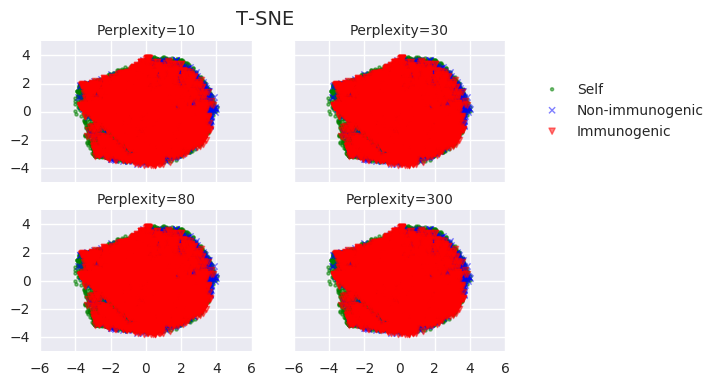

In [84]:
from pylab import *

def plot_tsne(tsne_data, perpl, axes):
#     plt.figure()
    axes.scatter(X_tsne[np.where(tsne_df.Immunogenicity == 2), 0],
                       X_tsne[np.where(tsne_df.Immunogenicity == 2), 1],
                       marker='.', color='g',
                       linewidth='1', alpha=0.5, label='Self')

    axes.scatter(X_tsne[np.where(tsne_df.Immunogenicity == 0), 0],
                       X_tsne[np.where(tsne_df.Immunogenicity == 0), 1],
                       marker='x', color='b',
                       linewidth='1', alpha=0.5, label='Non-immunogenic')
    axes.scatter(X_tsne[np.where(tsne_df.Immunogenicity == 1), 0],
                       X_tsne[np.where(tsne_df.Immunogenicity == 1), 1],
                       marker='v', color='r',
                       linewidth='1', alpha=0.5, label='Immunogenic')
    axes.set_title("Perplexity={0}".format(perpl), fontsize=10)
#     axes.xlabel('Dim 1')
#     axes.ylabel('Dim 2')
    # plt.savefig('1.png')

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')

plot_tsne(tsne_vecs[1], perpl[1], axes=ax1)
plot_tsne(tsne_vecs[3], perpl[3], axes=ax2)
plot_tsne(tsne_vecs[5], perpl[5], axes=ax3)
plot_tsne(tsne_vecs[9], perpl[9], axes=ax4)

# plt.title('T-SNE')
plt.legend(bbox_to_anchor=(2.0, 2.0), fontsize=10)
fig.suptitle('T-SNE', fontsize=14)

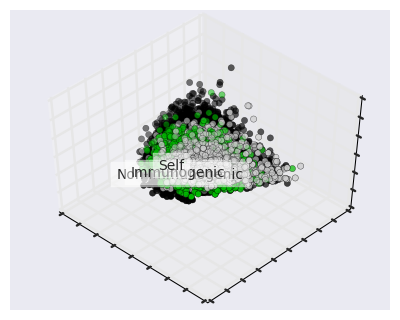

In [97]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


from sklearn import decomposition

np.random.seed(5)

centers = [[1, 1], [-1, -1], [1, -1]]
X = tsne_df[features]
y = tsne_df["Immunogenicity"]

fig = plt.figure(1, figsize=(4, 3))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)
# ax = Axes3D(fig, rect=None, elev=100, azim=80)

plt.cla()
pca = decomposition.PCA(n_components=3)
pca.fit(X)
X = pca.transform(X)

for name, label in [('Non-immunogenic', 0), ('Immunogenic', 1), ('Self', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 0.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap=plt.cm.spectral,
           edgecolor='k')

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()

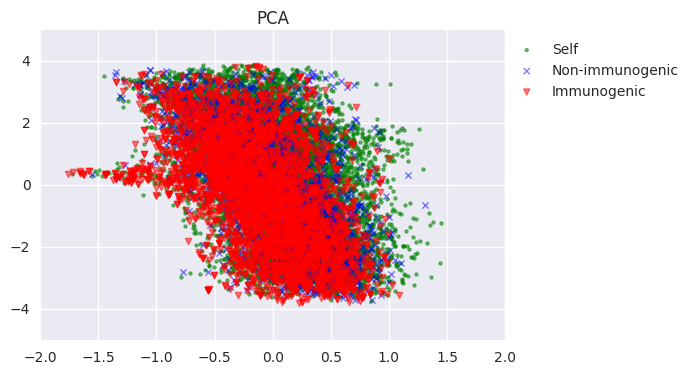

In [104]:
X = tsne_df[features]
y = tsne_df["Immunogenicity"]

pca = decomposition.PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

fig, ax = plt.subplots()

ax.scatter(X_pca[np.where(y == 2), 0],
                       X_tsne[np.where(tsne_df.Immunogenicity == 2), 1],
                       marker='.', color='g',
                       linewidth='1', alpha=0.5, label='Self')
ax.scatter(X_pca[np.where(y == 0), 0],
                   X_tsne[np.where(tsne_df.Immunogenicity == 0), 1],
                   marker='x', color='b',
                   linewidth='1', alpha=0.5, label='Non-immunogenic')
ax.scatter(X_pca[np.where(y == 1), 0],
                   X_tsne[np.where(tsne_df.Immunogenicity == 1), 1],
                   marker='v', color='r',
                   linewidth='1', alpha=0.5, label='Immunogenic')
plt.title("PCA")
plt.legend(bbox_to_anchor=(1.40, 1.0))

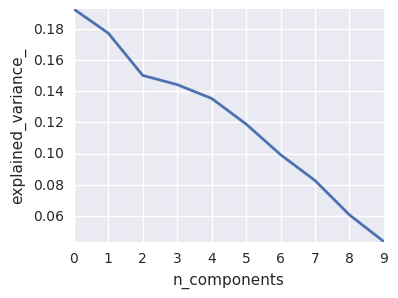

In [107]:
X = tsne_df[features]
y = tsne_df["Immunogenicity"]

pca = decomposition.PCA(n_components=10)
pca.fit(X)
X_pca = pca.transform(X)

plt.figure(1, figsize=(4, 3))
plt.clf()
# plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

In [109]:
pdf[features].shape

(10379346, 10)

In [128]:
center = pdf[features].mean()
center_std = pdf[features].std()
for i in center.index:
    print("mean {0:<20} is {1:^12.3f} std {2:>.3f}".format(i, center[i], center_std[i]))

mean helix.bend.pref      is    -0.049    std 0.402
mean side.chain.size      is    -0.216    std 0.352
mean extended.str.pref    is    -0.034    std 0.368
mean hydrophobicity       is    0.113     std 0.356
mean double.bend.pref     is    -0.101    std 0.327
mean partial.spec.vol     is    -0.287    std 0.327
mean flat.ext.pref        is    0.028     std 0.363
mean occurrence.alpha.reg is    -0.110    std 0.389
mean pK.C                 is    -0.014    std 0.298
mean surrounding.hydrop   is    0.025     std 0.323


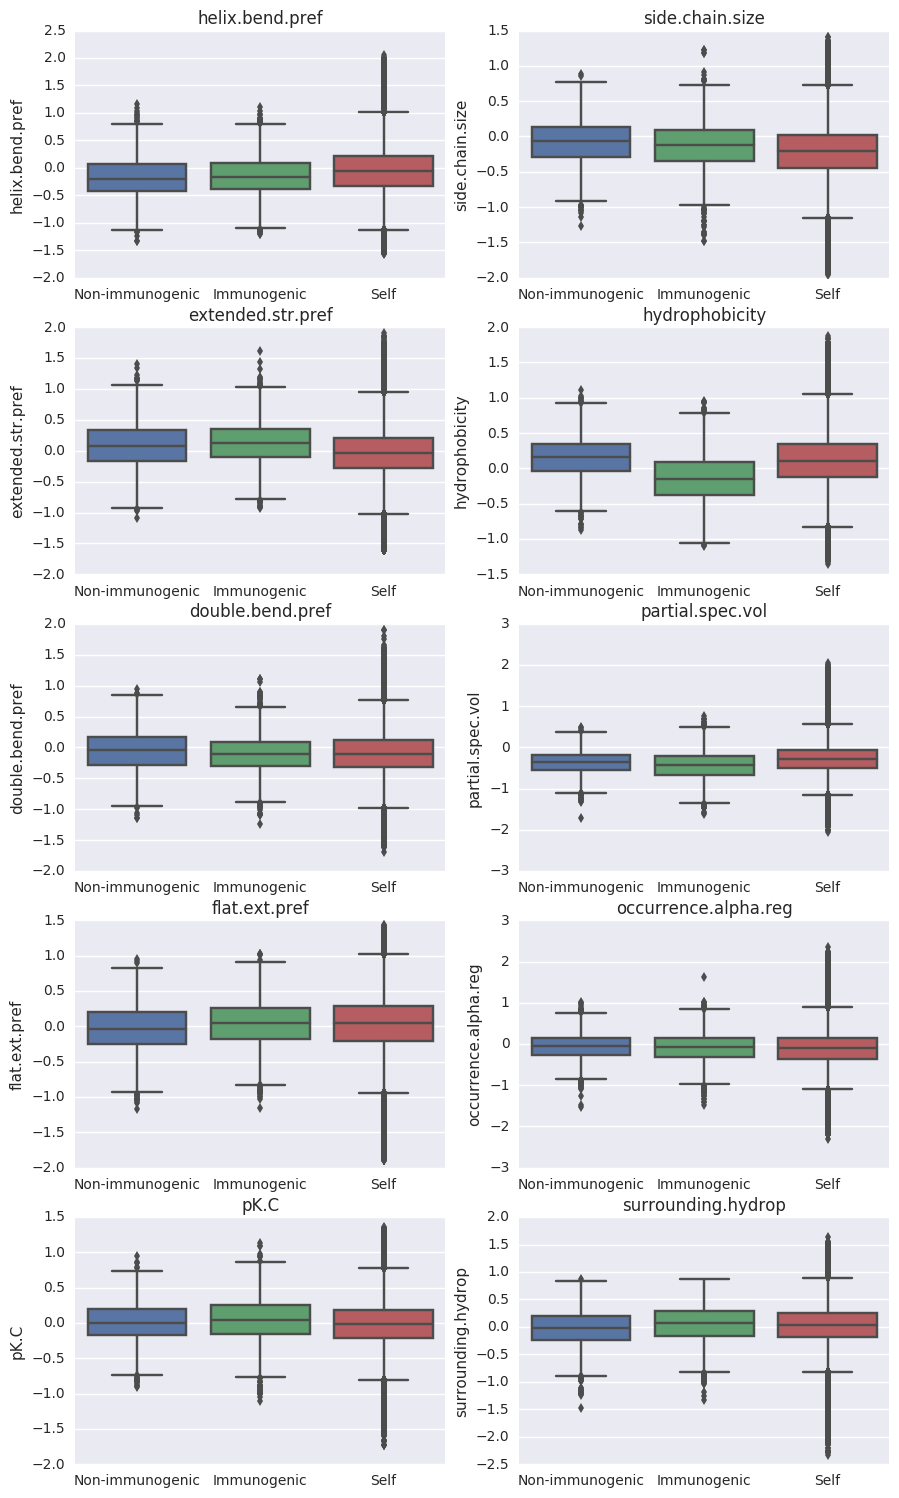

In [139]:
def plot_prop(prop, ax):
    sns.boxplot(x="Immunogenicity", y=prop, data=tdf, ax=ax)
    labels = ['Non-immunogenic', 'Immunogenic', 'Self']
    ax.set_xticklabels(labels)
    ax.set_xlabel("")
    ax.set_title(prop)

props = center.index
fig, axs = plt.subplots(5, 2)
fig.set_size_inches(10.5, 18.5)
n = 0
for ax1, ax2 in axs:
    plot_prop(props[n], ax1)
    n+=1
    plot_prop(props[n], ax2)
    n+=1

In [140]:
noself.shape

(6733, 12)

In [157]:
a = noself[features].iloc[0:2,:]
b = pdf[features].iloc[0:2,:]
dist = np.linalg.norm(a-b)
dist

3.6092311345653729

In [4]:
import multiprocessing as mp
 
cores = mp.cpu_count() #Number of CPU cores on your system
partitions = cores #Define as many partitions as you want

df1 = noself[features]
df2 = pdf[features]
df3 = noself[features].values
df4 = pdf[features].values

def np_distance(inds):
    return np.linalg.norm(df3[inds[0],:] - df4[inds[1],:])
 
# def distance(inds):
#     a, b = inds
#     return np.linalg.norm(df1.iloc[a,:] - df2.iloc[b,:])

# with mp.Pool(cores) as pool:
#     res = pool.map(distance, [(0, i) for i in range(len(pdf))])

In [ ]:
dist = []
with mp.Pool(cores) as pool:
    for j in trange(len(noself)):
        imres = np.array(pool.map(np_distance, [(j, i) for i in range(len(pdf))]))
        top_ind = np.argpartition(imres, -np.int(len(pdf)*0.05))[-np.int(len(pdf)*0.05):]
        dist.append(imres[top_ind].mean())

In [ ]:
from scipy.spatial.distance import cdist

Y = cdist(df3, df4, "euclidean")

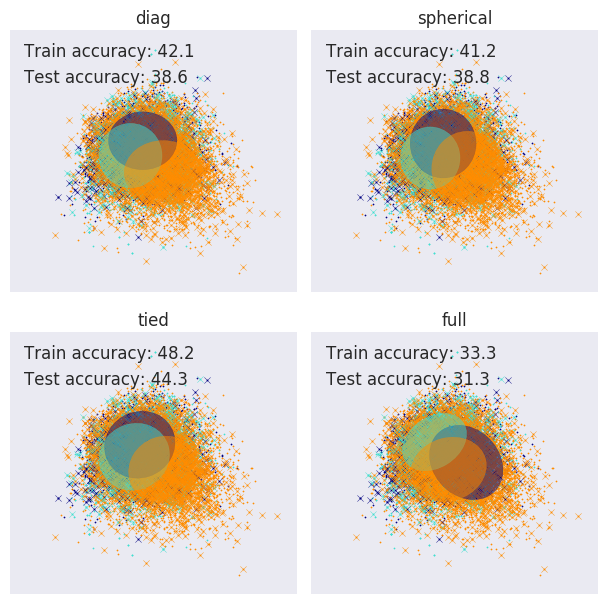

In [70]:
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold

# print(__doc__)

colors = ['navy', 'turquoise', 'darkorange']


def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)

# Break up the dataset into non-overlapping training (75%) and testing
# (25%) sets.
skf = StratifiedKFold(n_splits=4)
# Only take the first fold.
train_index, test_index = next(iter(skf.split(tsne_df[features], tsne_df["Immunogenicity"])))


X_train = tsne_df[features].iloc[train_index,:]
y_train = tsne_df["Immunogenicity"][train_index]
X_test = tsne_df[features].iloc[test_index,:]
y_test = tsne_df["Immunogenicity"][test_index]

n_classes = len(np.unique(y_train))

# Try GMMs using different types of covariances.
estimators = dict((cov_type, GaussianMixture(n_components=n_classes,
                   covariance_type=cov_type, max_iter=20, random_state=0))
                  for cov_type in ['spherical', 'diag', 'tied', 'full'])

n_estimators = len(estimators)

plt.figure(figsize=(3 * n_estimators // 2, 6))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)


for index, (name, estimator) in enumerate(estimators.items()):
    # Since we have class labels for the training data, we can
    # initialize the GMM parameters in a supervised manner.
    estimator.means_init = np.array([X_train[y_train == i].mean(axis=0)
                                    for i in range(n_classes)])

    # Train the other parameters using the EM algorithm.
    estimator.fit(X_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    for n, color in enumerate(colors):
        data = tsne_df[features].iloc[np.where(tsne_df["Immunogenicity"] == n)]
        target_names = tsne_df['Immunogenicity'].map({0:'Non-immunogenic', 1:'Immunogenic', 2:'Self'})
        plt.scatter(data.iloc[:, 0], data.iloc[:, 1], s=0.8, color=color,
                    label=target_names[n])
    # Plot the test data with crosses
    for n, color in enumerate(colors):
        data = X_test[y_test == n]
        plt.scatter(data.iloc[:, 0], data.iloc[:, 1], marker='x', color=color,
                    label=target_names[n])

    y_train_pred = estimator.predict(X_train)
    train_accuracy = np.mean(y_train_pred.ravel() == y_train.ravel()) * 100
    plt.text(0.05, 0.9, 'Train accuracy: %.1f' % train_accuracy,
             transform=h.transAxes)

    y_test_pred = estimator.predict(X_test)
    test_accuracy = np.mean(y_test_pred.ravel() == y_test.ravel()) * 100
    plt.text(0.05, 0.8, 'Test accuracy: %.1f' % test_accuracy,
             transform=h.transAxes)

    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend("")


plt.show()

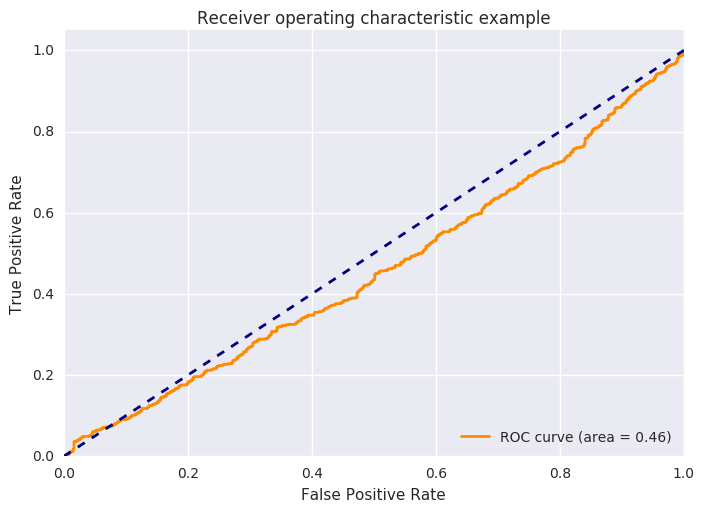

In [81]:
from sklearn.metrics import roc_curve, auc

skf = StratifiedKFold(n_splits=4)
train_index, test_index = next(iter(skf.split(noself[features], noself["Immunogenicity"])))


X_train = noself[features].iloc[train_index,:]
y_train = noself["Immunogenicity"][train_index]
X_test = noself[features].iloc[test_index,:]
y_test = noself["Immunogenicity"][test_index]

gmm = GaussianMixture(n_components=3, covariance_type='tied',
                              max_iter=100).fit(X_train, y_train)
y_score = gmm.score_samples(X_test)

fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

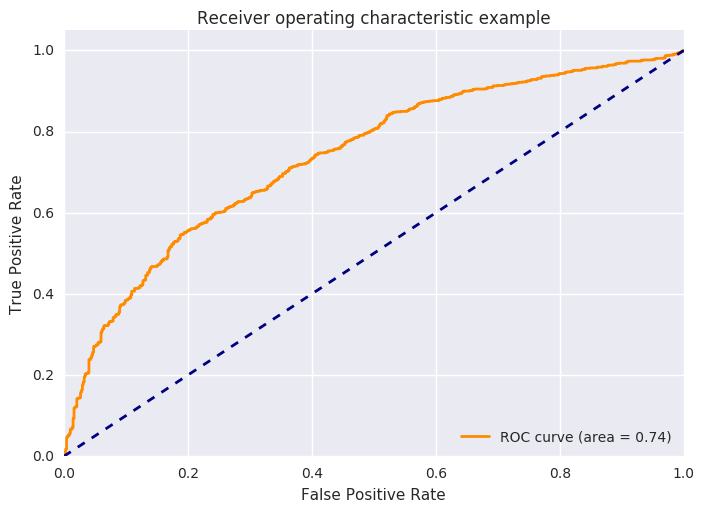

In [87]:
from sklearn import svm

skf = StratifiedKFold(n_splits=4)
train_index, test_index = next(iter(skf.split(noself[features], noself["Immunogenicity"])))

X_train = noself[features].iloc[train_index,:]
y_train = noself["Immunogenicity"][train_index]
X_test = noself[features].iloc[test_index,:]
y_test = noself["Immunogenicity"][test_index]

clf = svm.SVC(kernel="poly", gamma=10)
y_score = clf.fit(X_train, y_train).decision_function(X_test)
    
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [88]:
from scipy.stats import randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
# Metrics
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score, f1_score

In [91]:
forest = RandomForestClassifier(100, max_features=None, min_samples_split=3, min_samples_leaf=3,\
                                random_state=42, n_jobs=-1, oob_score=True)
forest.fit(X_train, y_train)
feats_imp = pd.DataFrame(forest.feature_importances_,
                        index=features, 
                        columns=['Importance']).sort_values(['Importance'], 
                                                     ascending=False)
feats_imp

Importance
hydrophobicity          0.337855
flat.ext.pref           0.087939
surrounding.hydrop      0.084037
partial.spec.vol        0.079601
helix.bend.pref         0.072458
double.bend.pref        0.072126
occurrence.alpha.reg    0.070800
side.chain.size         0.065765
extended.str.pref       0.064858
pK.C                    0.064561

In [92]:
knn = KNeighborsClassifier(n_neighbors=10)
dectree = DecisionTreeClassifier(max_depth=None, min_samples_split=2)
extree = ExtraTreesClassifier(n_estimators=10, max_depth=None, min_samples_split=2)
grboost = GradientBoostingClassifier(n_estimators=10, learning_rate=1.0, max_depth=1)
#mlp = MLPClassifier(random_state=42)
svclf = SVC(random_state=42)
gpc = GaussianProcessClassifier()
clfs = [knn, dectree, extree, grboost, svclf, gpc, forest]
cv = StratifiedKFold(n_splits=10)
for clf in clfs:
    print(type(clf).__name__, np.mean(cross_val_score(clf, X_train, y_train, cv=cv, scoring="roc_auc", n_jobs=-1)))

KNeighborsClassifier 0.787629860475
DecisionTreeClassifier 0.671826219803
ExtraTreesClassifier 0.80767687609
GradientBoostingClassifier 0.777073961121
SVC 0.808987035036
GaussianProcessClassifier 0.816742203221
RandomForestClassifier 0.82655872559


In [93]:
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_dist = {"max_depth": [3, 5, 7],
              "n_estimators": np.arange(2, 100, 2),
              "max_features": np.arange(2, 8),
              "min_samples_split": np.arange(2, 8),
              "min_samples_leaf": np.arange(2, 100, 2),
              "criterion": ["gini", "entropy"]}

n_iter_search = 20
random_search = RandomizedSearchCV(forest, param_distributions=param_dist,
                                   n_iter=n_iter_search, scoring="roc_auc", n_jobs=-1)

random_search.fit(X_train, y_train)
print("RandomizedSearchCV for %d candidates"
      " parameter settings." % (n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV for 20 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.799 (std: 0.048)
Parameters: {'n_estimators': 34, 'max_features': 5, 'criterion': 'entropy', 'min_samples_split': 5, 'max_depth': 7, 'min_samples_leaf': 46}

Model with rank: 2
Mean validation score: 0.799 (std: 0.051)
Parameters: {'n_estimators': 58, 'max_features': 5, 'criterion': 'entropy', 'min_samples_split': 2, 'max_depth': 5, 'min_samples_leaf': 24}

Model with rank: 3
Mean validation score: 0.797 (std: 0.050)
Parameters: {'n_estimators': 88, 'max_features': 4, 'criterion': 'gini', 'min_samples_split': 6, 'max_depth': 7, 'min_samples_leaf': 46}



In [99]:
roc_auc_score(y_test, forest.predict_proba(X_test)[:, 1])

0.77311619084703564

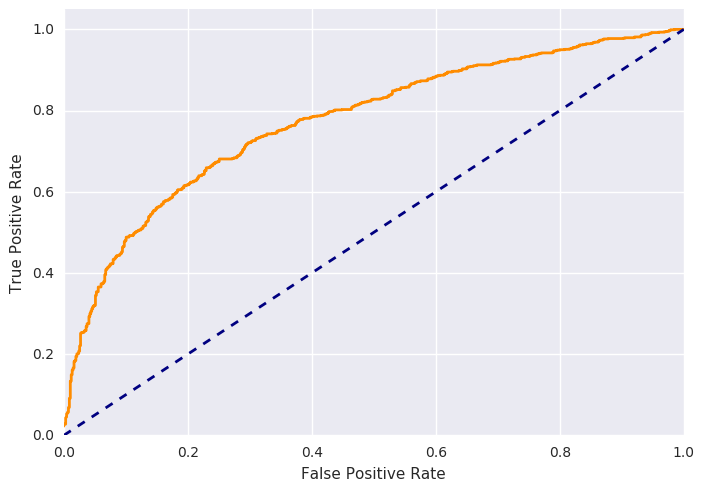

In [98]:
fpr, tpr, thresholds = roc_curve(y_test, forest.predict_proba(X_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show();